# Lesson 2: NYC 311 calls

This notebook derives from a [demo by the makers of plot.ly](https://plot.ly/ipython-notebooks/big-data-analytics-with-pandas-and-sqlite/). We've adapted it to use [Bokeh (and HoloViews)](http://bokeh.pydata.org/en/latest/).

You will start with a large database of complaints filed by residents of New York City since 2010 via 311 calls. The full dataset is available at the [NYC open data portal](https://nycopendata.socrata.com/data). At about 6 GB and 10 million complaints, you can infer that a) you might not want to read it all into memory at once, and b) NYC residents have a lot to complain about. (Maybe only conclusion "a" is valid.) The notebook then combines the use of `sqlite`, `pandas`, and `bokeh`.

## Module setup

Before diving in, run the following cells to preload some functions you'll need later.

In [1]:
from IPython.display import display
import pandas as pd

We'll also need some functionality from earlier notebooks.

In [2]:
def canonicalize_tibble(X):
    var_names = sorted(X.columns)
    Y = X[var_names].copy()
    Y.sort_values(by=var_names, inplace=True)
    Y.reset_index(drop=True, inplace=True)
    return Y

def tibbles_are_equivalent (A, B):
    A_canonical = canonicalize_tibble(A)
    B_canonical = canonicalize_tibble(B)
    cmp = A_canonical.eq(B_canonical)
    return cmp.all().all()

def cast(df, key, value, join_how='outer'):
    """Casts the input data frame into a tibble,
    given the key column and value column.
    """
    assert type(df) is pd.DataFrame
    assert key in df.columns and value in df.columns
    assert join_how in ['outer', 'inner']
    
    fixed_vars = df.columns.difference([key, value])
    tibble = pd.DataFrame(columns=fixed_vars) # empty frame    
    new_vars = df[key].unique()
    for v in new_vars:
        df_v = df[df[key] == v]
        del df_v[key]
        df_v = df_v.rename(columns={value: v})
        tibble = tibble.merge(df_v,
                              on=list(fixed_vars),
                              how=join_how)    
    return tibble

Lastly, some of the test cells will need some auxiliary files, which the following code cell will check for and, if they are missing, download.

In [3]:
import requests
import os
import hashlib
import io

def download(file, url_suffix=None, checksum=None):
    if url_suffix is None:
        url_suffix = file
        
    if os.path.exists('.voc'):
        url = 'https://cse6040.gatech.edu/datasets/{}'.format(url_suffix)
    else:
        url = 'https://github.com/cse6040/labs-fa17/raw/master/{}'.format(url_suffix)
    if os.path.exists(file):
        print("[{}]\n==> '{}' is already available.".format(url, file))
    else:
        print("[{}] Downloading...".format(url))
        r = requests.get(url)
        with open(file, 'w', encoding=r.encoding) as f:
            f.write(r.text)
            
    if checksum is not None:
        with io.open(file, 'r', encoding='utf-8', errors='replace') as f:
            body = f.read()
            body_checksum = hashlib.md5(body.encode('utf-8')).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(file, body_checksum, checksum)
            print("==> Checksum test passes: {}".format(checksum))
    
    print("==> '{}' is ready!\n".format(file))
    
auxfiles = {'df_complaints_by_city_soln.csv': '2a82e5856d5a267db9aafc26f16c3ae1',
            'df_complaints_by_hour_soln.csv': 'f06fcd917876d51ad52ddc13b2fee69e',
            'df_noisy_by_hour_soln.csv': '30f3fa7c753d4d3f4b3edfa1f6d05bcc',
            'df_plot_stacked_fraction_soln.csv': '2ca04a3eb24ccc37ddd0f8f5917fb27a'}

for filename, checksum in auxfiles.items():
    download(filename, url_suffix='{}/{}'.format('lab9-sql', filename), checksum=checksum)
    
print("(Auxiliary files appear to be ready.)")

[https://cse6040.gatech.edu/datasets/lab9-sql/df_noisy_by_hour_soln.csv]
==> 'df_noisy_by_hour_soln.csv' is already available.
==> Checksum test passes: 30f3fa7c753d4d3f4b3edfa1f6d05bcc
==> 'df_noisy_by_hour_soln.csv' is ready!

[https://cse6040.gatech.edu/datasets/lab9-sql/df_plot_stacked_fraction_soln.csv]
==> 'df_plot_stacked_fraction_soln.csv' is already available.
==> Checksum test passes: 2ca04a3eb24ccc37ddd0f8f5917fb27a
==> 'df_plot_stacked_fraction_soln.csv' is ready!

[https://cse6040.gatech.edu/datasets/lab9-sql/df_complaints_by_hour_soln.csv]
==> 'df_complaints_by_hour_soln.csv' is already available.
==> Checksum test passes: f06fcd917876d51ad52ddc13b2fee69e
==> 'df_complaints_by_hour_soln.csv' is ready!

[https://cse6040.gatech.edu/datasets/lab9-sql/df_complaints_by_city_soln.csv]
==> 'df_complaints_by_city_soln.csv' is already available.
==> Checksum test passes: 2a82e5856d5a267db9aafc26f16c3ae1
==> 'df_complaints_by_city_soln.csv' is ready!

(Auxiliary files appear to be 

## Viz setup

This notebook includes some simple visualizations. This section just ensures you have the right software setup to follow along.

In [4]:
from bokeh.io import show, output_notebook
output_notebook()

from bokeh.plotting import figure

def make_barchart(df, labels, values, kwargs_figure={}):
    assert type(df) is pd.DataFrame
    assert type(labels) is str and type(values) is str
    p = figure(x_range=list(df[labels].unique()), **kwargs_figure)
    p.vbar(x=list(df[labels]), top=list(df[values]), width=0.9)
    return p

Loading BokehJS ...

In [5]:
# Adapted from: https://bokeh.pydata.org/en/latest/docs/user_guide/categorical.html#userguide-categorical
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.core.properties import value

def make_stacked_bar(df, x_var, bar_vars, kwargs_figure={}):
    assert type(x_var) is str, "x-variable should be a string but isn't."
    assert all([b in df.columns for b in bar_vars]), "Data frame is missing one or more columns: {}".format(bar_vars)
    
    from bokeh.palettes import brewer
    assert len(bar_vars) in brewer['Dark2'], "Not enough colors."
    
    x = list(df[x_var])
    colors = brewer['Dark2'][len(bar_vars)]
    legend = [value(b) for b in bar_vars]
    source = ColumnDataSource(data=df)

    p = figure(x_range=x, **kwargs_figure)
    p.vbar_stack(bar_vars, x=x_var, width=0.9,
             fill_color=colors, line_color=None,
             legend=legend,
             source=source)
    return p

In [6]:
# Build a Pandas data frame
names = ['Bob','Jessica','Mary','John','Mel']
births = [968, 155, 77, 578, 973]
name_birth_pairs = list(zip(names, births))
baby_names = pd.DataFrame(data=name_birth_pairs, columns=['Names', 'Births'])
display(baby_names)

,Names,Births
0,Bob,968
1,Jessica,155
2,Mary,77
3,John,578
4,Mel,973


In [7]:
p = make_barchart(baby_names, 'Names', 'Births', kwargs_figure={'plot_width': 640, 'plot_height': 320})
show(p)

## Data setup

You'll also need the NYC 311 calls dataset. What we've provided is actually a small subset (about 250+ MiB) of the full data as of 2015.

In [8]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

if on_vocareum():
    DB_FILENAME = "../resource/lib/publicdata/NYC-311-2M.db"
else:
    DB_FILENAME = 'NYC-311-2M.db'
    if not os.path.exists(DB_FILENAME):
        url = 'https://onedrive.live.com/download?cid=FD520DDC6BE92730&resid=FD520DDC6BE92730%21616&authkey=AEeP_4E1uh-vyDE'
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(DB_FILENAME, 'w', encoding=r.encoding) as f:
            f.write(r.text)

DB_CHECKSUM = 'f48eba2fb06e8ece7479461ea8c6dee9'
with io.open(DB_FILENAME, 'rb') as f:
    body = f.read()
    body_checksum = hashlib.md5(body).hexdigest()
    assert body_checksum == DB_CHECKSUM, \
        "Database file '{}' has an incorrect checksum: '{}' instead of '{}'".format(DB_FILENAME,
                                                                                    body_checksum,
                                                                                    DB_CHECKSUM)
    
print("'{}' is ready!".format(DB_FILENAME))  
print("\n(All data appears to be ready.)")

'../resource/lib/publicdata/NYC-311-2M.db' is ready!

(All data appears to be ready.)


**Connecting.** Let's open up a connection to this dataset.

In [9]:
# Connect
import sqlite3 as db
disk_engine = db.connect(DB_FILENAME)

**Preview the data.** This sample database has just a single table, named `data`. Let's query it and see how long it takes to read. To carry out the query, we will use the SQL reader built into `pandas`.

In [10]:
import time

print ("Reading ...")
start_time = time.time ()

# Perform SQL query through the disk_engine connection.
# The return value is a pandas data frame.
df = pd.read_sql_query ('select * from data', disk_engine)

elapsed_time = time.time () - start_time
print ("==> Took %g seconds." % elapsed_time)

# Dump the first few rows
df.head()

Reading ...
==> Took 7.45167 seconds.


,index,CreatedDate,ClosedDate,Agency,ComplaintType,Descriptor,City
0,1,2015-09-15 02:14:04.000000,None,NYPD,Illegal Parking,Blocked Hydrant,None
1,2,2015-09-15 02:12:49.000000,None,NYPD,Noise - Street/Sidewalk,Loud Talking,NEW YORK
2,3,2015-09-15 02:11:19.000000,None,NYPD,Noise - Street/Sidewalk,Loud Talking,NEW YORK
3,4,2015-09-15 02:09:46.000000,None,NYPD,Noise - Commercial,Loud Talking,BRONX
4,5,2015-09-15 02:08:01.000000,2015-09-15 02:08:18.000000,DHS,Homeless Person Assistance,Status Call,NEW YORK


**Partial queries: `LIMIT` clause.** The preceding command was overkill for what we wanted, which was just to preview the table. Instead, we could have used the `LIMIT` option to ask for just a few results.

In [11]:
query = '''
  select *
    from data
    limit 5
'''
start_time = time.time ()
df = pd.read_sql_query (query, disk_engine)
elapsed_time = time.time () - start_time
print ("==> LIMIT version took %g seconds." % elapsed_time)

df

==> LIMIT version took 0.00327444 seconds.


,index,CreatedDate,ClosedDate,Agency,ComplaintType,Descriptor,City
0,1,2015-09-15 02:14:04.000000,None,NYPD,Illegal Parking,Blocked Hydrant,None
1,2,2015-09-15 02:12:49.000000,None,NYPD,Noise - Street/Sidewalk,Loud Talking,NEW YORK
2,3,2015-09-15 02:11:19.000000,None,NYPD,Noise - Street/Sidewalk,Loud Talking,NEW YORK
3,4,2015-09-15 02:09:46.000000,None,NYPD,Noise - Commercial,Loud Talking,BRONX
4,5,2015-09-15 02:08:01.000000,2015-09-15 02:08:18.000000,DHS,Homeless Person Assistance,Status Call,NEW YORK


**Grouping Information: GROUP BY operator.** The GROUP BY operator lets you group information using a particular column or multiple columns of the table. The output generated is more of a pivot table.

In [12]:
query = '''
  select ComplaintType, Descriptor, Agency
    from data
    GROUP BY ComplaintType
    limit 10
'''

df = pd.read_sql_query(query, disk_engine)
df.head()

,ComplaintType,Descriptor,Agency
0,AGENCY,HOUSING QUALITY STANDARDS,HPD
1,APPLIANCE,REFRIGERATOR,HPD
2,Adopt-A-Basket,10A Adopt-A-Basket,DSNY
3,Agency Issues,Call Center Compliment,3-1-1
4,Air Quality,"Air: Odor/Fumes, Vehicle Idling (AD3)",DEP


In [13]:
query = '''
  select ComplaintType, Descriptor, Agency
    from data
    limit 10
'''

df = pd.read_sql_query(query, disk_engine)
df.head()

,ComplaintType,Descriptor,Agency
0,Illegal Parking,Blocked Hydrant,NYPD
1,Noise - Street/Sidewalk,Loud Talking,NYPD
2,Noise - Street/Sidewalk,Loud Talking,NYPD
3,Noise - Commercial,Loud Talking,NYPD
4,Homeless Person Assistance,Status Call,DHS


**Set membership: `IN` operator.** Another common idiom is to ask for rows whose attributes fall within a set, for which you can use the `IN` operator.

In [14]:
query = '''
  select ComplaintType, Descriptor, Agency
    from data
    where Agency IN ("NYPD", "DOB")
    limit 10
'''

df = pd.read_sql_query (query, disk_engine)
df.head ()

,ComplaintType,Descriptor,Agency
0,Illegal Parking,Blocked Hydrant,NYPD
1,Noise - Street/Sidewalk,Loud Talking,NYPD
2,Noise - Street/Sidewalk,Loud Talking,NYPD
3,Noise - Commercial,Loud Talking,NYPD
4,Blocked Driveway,Partial Access,NYPD


**Finding unique values: `DISTINCT` qualifier.** Yet another common idiom is to ask for the unique values of some attribute, for which you can use the `DISTINCT` qualifier.

In [15]:
query = 'select DISTINCT City FROM data'
df = pd.read_sql_query(query, disk_engine)

print("Found {} unique cities. The first few are:".format(len(df)))
df.head()

Found 547 unique cities. The first few are:


,City
0,None
1,NEW YORK
2,BRONX
3,STATEN ISLAND
4,ELMHURST


**Renaming columns: `AS` operator.** Sometimes you might want to rename a result column. For instance, the following query counts the number of complaints by "Agency," using the `COUNT(*)` function and `GROUP BY` clause, which we discussed in an earlier lab. If you wish to refer to the counts column of the resulting data frame, you can give it a more "friendly" name using the `AS` operator.

In [16]:
query = '''
  select Agency, count(*) as NumComplaints
    from data
    group by Agency
'''
df = pd.read_sql_query(query, disk_engine)
df.head()

,Agency,NumComplaints
0,3-1-1,1289
1,ACS,3
2,AJC,6
3,CAU,1
4,CCRB,1


**Ordering results: `ORDER` clause.** You can also order the results. For instance, suppose we want to execute the previous query by number of complaints.

In [17]:
query = '''
  select Agency, count(*) as NumComplaints
    from data
    group by Agency
    order by NumComplaints
'''
df = pd.read_sql_query(query, disk_engine)
df.tail()

,Agency,NumComplaints
45,DSNY,152004
46,DEP,181121
47,DOT,322969
48,NYPD,340694
49,HPD,640096


Note that the above example prints the bottom (tail) of the data frame. You could have also asked for the query results in reverse (descending) order, by prefixing the `ORDER BY` attribute with a `-` (minus) symbol.

In [18]:
query = '''
  select Agency, count(*) as NumComplaints
    from data
    group by Agency
    order by -NumComplaints
'''
df = pd.read_sql_query(query, disk_engine)
df.head()

,Agency,NumComplaints
0,HPD,640096
1,NYPD,340694
2,DOT,322969
3,DEP,181121
4,DSNY,152004


And of course we can plot all of this data!

**Exercise 0** (ungraded). Run the following code cell, which will create an interactive bar chart from the data in the previous query.

In [19]:
p = make_barchart(df[:20], 'Agency', 'NumComplaints',
                  {'title': 'Top 20 agencies by number of complaints',
                   'plot_width': 800, 'plot_height': 320})
p.xaxis.major_label_orientation = 0.66
show(p)

**Exercise 1** (2 points). Create a string, `query`, containing an SQL query that will return the number of complaints by type. The columns should be named `type` and `freq`, and the results should be sorted in descending order by `freq`.

> What is the most common type of complaint? What, if anything, does it tell you about NYC?

In [20]:
del query

# Define a variable named `query` containing your solution
# YOUR CODE HERE
query = '''SELECT ComplaintType AS type, count(*) AS freq
                FROM data GROUP BY ComplaintType
                ORDER BY -freq'''

# Runs your `query`:
df_complaint_freq = pd.read_sql_query(query, disk_engine)
df_complaint_freq.head()

,type,freq
0,HEAT/HOT WATER,241430
1,Street Condition,124347
2,Street Light Condition,98577
3,Blocked Driveway,95080
4,Illegal Parking,83961


In [21]:
# Test cell: `complaints_test`

print("Top 10 complaints:")
display(df_complaint_freq.head(10))

assert set(df_complaint_freq.columns) == {'type', 'freq'}, "Output columns should be named 'type' and 'freq', not {}".format(set(df_complaint_freq.columns))

soln = ['HEAT/HOT WATER', 'Street Condition', 'Street Light Condition', 'Blocked Driveway', 'Illegal Parking', 'UNSANITARY CONDITION', 'PAINT/PLASTER', 'Water System', 'PLUMBING', 'Noise', 'Noise - Street/Sidewalk', 'Traffic Signal Condition', 'Noise - Commercial', 'DOOR/WINDOW', 'WATER LEAK', 'Dirty Conditions', 'Sewer', 'Sanitation Condition', 'DOF Literature Request', 'ELECTRIC', 'Rodent', 'FLOORING/STAIRS', 'General Construction/Plumbing', 'Building/Use', 'Broken Muni Meter', 'GENERAL', 'Missed Collection (All Materials)', 'Benefit Card Replacement', 'Derelict Vehicle', 'Noise - Vehicle', 'Damaged Tree', 'Consumer Complaint', 'Derelict Vehicles', 'Taxi Complaint', 'Overgrown Tree/Branches', 'Graffiti', 'Snow', 'Opinion for the Mayor', 'APPLIANCE', 'Maintenance or Facility', 'Animal Abuse', 'Dead Tree', 'HPD Literature Request', 'Root/Sewer/Sidewalk Condition', 'SAFETY', 'Elevator', 'Food Establishment', 'SCRIE', 'Air Quality', 'Agency Issues', 'Construction', 'Highway Condition', 'Other Enforcement', 'Water Conservation', 'Sidewalk Condition', 'Indoor Air Quality', 'Street Sign - Damaged', 'Traffic', 'Plumbing', 'Fire Safety Director - F58', 'Homeless Person Assistance', 'Homeless Encampment', 'Special Enforcement', 'Street Sign - Missing', 'Noise - Park', 'Vending', 'For Hire Vehicle Complaint', 'Food Poisoning', 'Special Projects Inspection Team (SPIT)', 'Hazardous Materials', 'Electrical', 'DOT Literature Request', 'Litter Basket / Request', 'Taxi Report', 'Illegal Tree Damage', 'DOF Property - Reduction Issue', 'Unsanitary Animal Pvt Property', 'Asbestos', 'Lead', 'Vacant Lot', 'DCA / DOH New License Application Request', 'Street Sign - Dangling', 'Smoking', 'Violation of Park Rules', 'OUTSIDE BUILDING', 'Animal in a Park', 'Noise - Helicopter', 'School Maintenance', 'DPR Internal', 'Boilers', 'Industrial Waste', 'Sweeping/Missed', 'Overflowing Litter Baskets', 'Non-Residential Heat', 'Curb Condition', 'Drinking', 'Standing Water', 'Indoor Sewage', 'Water Quality', 'EAP Inspection - F59', 'Derelict Bicycle', 'Noise - House of Worship', 'DCA Literature Request', 'Recycling Enforcement', 'ELEVATOR', 'DOF Parking - Tax Exemption', 'Broken Parking Meter', 'Request for Information', 'Taxi Compliment', 'Unleashed Dog', 'Urinating in Public', 'Unsanitary Pigeon Condition', 'Investigations and Discipline (IAD)', 'Bridge Condition', 'Ferry Inquiry', 'Bike/Roller/Skate Chronic', 'Public Payphone Complaint', 'Vector', 'BEST/Site Safety', 'Sweeping/Inadequate', 'Disorderly Youth', 'Found Property', 'Mold', 'Senior Center Complaint', 'Fire Alarm - Reinspection', 'For Hire Vehicle Report', 'City Vehicle Placard Complaint', 'Cranes and Derricks', 'Ferry Complaint', 'Illegal Animal Kept as Pet', 'Posting Advertisement', 'Harboring Bees/Wasps', 'Panhandling', 'Scaffold Safety', 'OEM Literature Request', 'Plant', 'Bus Stop Shelter Placement', 'Collection Truck Noise', 'Beach/Pool/Sauna Complaint', 'Complaint', 'Compliment', 'Illegal Fireworks', 'Fire Alarm - Modification', 'DEP Literature Request', 'Drinking Water', 'Fire Alarm - New System', 'Poison Ivy', 'Bike Rack Condition', 'Emergency Response Team (ERT)', 'Municipal Parking Facility', 'Tattooing', 'Unsanitary Animal Facility', 'Animal Facility - No Permit', 'Miscellaneous Categories', 'Misc. Comments', 'Literature Request', 'Special Natural Area District (SNAD)', 'Highway Sign - Damaged', 'Public Toilet', 'Adopt-A-Basket', 'Ferry Permit', 'Invitation', 'Window Guard', 'Parking Card', 'Illegal Animal Sold', 'Stalled Sites', 'Open Flame Permit', 'Overflowing Recycling Baskets', 'Highway Sign - Missing', 'Public Assembly', 'DPR Literature Request', 'Fire Alarm - Addition', 'Lifeguard', 'Transportation Provider Complaint', 'DFTA Literature Request', 'Bottled Water', 'Highway Sign - Dangling', 'DHS Income Savings Requirement', 'Legal Services Provider Complaint', 'Foam Ban Enforcement', 'Tunnel Condition', 'Calorie Labeling', 'Fire Alarm - Replacement', 'X-Ray Machine/Equipment', 'Sprinkler - Mechanical', 'Hazmat Storage/Use', 'Tanning', 'Radioactive Material', 'Rangehood', 'SRDE', 'Squeegee', 'Building Condition', 'SG-98', 'Standpipe - Mechanical', 'AGENCY', 'Forensic Engineering', 'Public Assembly - Temporary', 'VACANT APARTMENT', 'Laboratory', 'SG-99']
assert all(soln == df_complaint_freq['type'])

print("\n(Passed.)")

Top 10 complaints:


,type,freq
0,HEAT/HOT WATER,241430
1,Street Condition,124347
2,Street Light Condition,98577
3,Blocked Driveway,95080
4,Illegal Parking,83961
5,UNSANITARY CONDITION,81394
6,PAINT/PLASTER,69929
7,Water System,69209
8,PLUMBING,55445
9,Noise,54165



(Passed.)


Let's also visualize the result, as a bar chart showing complaint types on the x-axis and the number of complaints on the y-axis.

In [22]:
p = make_barchart(df_complaint_freq[:25], 'type', 'freq',
                  {'title': 'Top 25 complaints by type',
                   'plot_width': 800, 'plot_height': 320})
p.xaxis.major_label_orientation = 0.66
show(p)

# Lesson 3: More SQL stuff

**Simple substring matching: the `LIKE` operator.** Suppose we just want to look at the counts for all complaints that have the word `noise` in them. You can use the `LIKE` operator combined with the string wildcard, `%`, to look for case-insensitive substring matches.

In [23]:
query = '''
  select ComplaintType as type, count(*) as freq
    from data
    where ComplaintType like '%noise%'
    group by type
    order by -freq
'''

df_noisy = pd.read_sql_query(query, disk_engine)
df_noisy

,type,freq
0,Noise,54165
1,Noise - Street/Sidewalk,48436
2,Noise - Commercial,42422
3,Noise - Vehicle,18370
4,Noise - Park,4020
5,Noise - Helicopter,1715
6,Noise - House of Worship,1143
7,Collection Truck Noise,184


**Exercise 2** (2 points). Create a string variable, `query`, that contains an SQL query that will return the top 10 cities with the largest number of complaints, in descending order. It should return a table with two columns, one named `name` holding the name of the city, and one named `freq` holding the number of complaints by that city.

In [24]:
del query

# Define your `query`, here:
# YOUR CODE HERE
query = '''SELECT City AS name, count(*) AS freq
            FROM data 
            GROUP BY name
            ORDER BY -freq'''

# Runs your `query`:
df_whiny_cities = pd.read_sql_query(query, disk_engine)
df_whiny_cities

,name,freq
0,BROOKLYN,579363
1,NEW YORK,385655
2,BRONX,342533
3,None,168692
4,STATEN ISLAND,92509
5,Jamaica,30435
6,Flushing,20708
7,Astoria,18068
8,JAMAICA,16248
9,FLUSHING,14796


In [25]:
# Test cell: `whiny_cities__test`

assert df_whiny_cities['name'][0] == 'BROOKLYN'
assert df_whiny_cities['name'][1] == 'NEW YORK'
assert df_whiny_cities['name'][2] == 'BRONX'
assert df_whiny_cities['name'][3] is None
assert df_whiny_cities['name'][4] == 'STATEN ISLAND'

print ("\n(Passed partial test.)")


(Passed partial test.)


You should notice two odd bits: cities are treated in a _case-sensitive_ manner and `None` appears as a city. (Presumably this setting occurs when a complaint is non-localized or the city is not otherwise specified.)

**Case-insensitive grouping: `COLLATE NOCASE`.** One way to carry out the preceding query in a case-insensitive way is to add a `COLLATE NOCASE` qualifier to the `GROUP BY` clause.

Let's filter out the 'None' cases as well, while we are at it.

In [26]:
query = '''
  SELECT City as name, COUNT(*) AS freq
    FROM data
    WHERE name <> 'None'
    GROUP BY name COLLATE NOCASE
    ORDER BY -freq
    LIMIT 10
'''
df_whiny_cities2 = pd.read_sql_query(query, disk_engine)
df_whiny_cities2

,name,freq
0,BROOKLYN,579363
1,NEW YORK,385655
2,BRONX,342533
3,STATEN ISLAND,92509
4,Jamaica,46683
5,Flushing,35504
6,ASTORIA,31873
7,Ridgewood,21618
8,Woodside,15932
9,Corona,15740


Brooklynites are complainers, evidently.

Lastly, for later use, let's save the names of just the top seven (7) cities by numbers of complaints.

In [27]:
TOP_CITIES = list(df_whiny_cities2.head(7)['name'])
TOP_CITIES

['BROOKLYN',
 'NEW YORK',
 'BRONX',
 'STATEN ISLAND',
 'Jamaica',
 'Flushing',
 'ASTORIA']

**Exercise 3** (1 point). Implement a function that takes a list of strings, `str_list`, and returns a single string consisting of each value, `str_list[i]`, enclosed by double-quotes and separated by a comma-space delimiters. For example, if

```python
   assert str_list == ['a', 'b', 'c', 'd']
```

then

```python
   assert strs_to_args(str_list) == '"a", "b", "c", "d"'
```

In [28]:
def strs_to_args(str_list):
    assert type (str_list) is list
    assert all ([type (s) is str for s in str_list])
    
    # YOUR CODE HERE
    str_convert = ''
    for item in str_list:
        if item == str_list[len(str_list)-1]:
            str_convert += '"'+item+'"'
        else:
            str_convert += '"'+item+'"'+', '
    return str_convert

# strs_to_args(['a', 'b', 'c', 'd'])


In [29]:
# Test cell: `strs_to_args__test`

print ("Your solution, applied to TOP_CITIES:", strs_to_args(TOP_CITIES))

TOP_CITIES_as_args = strs_to_args(TOP_CITIES)
assert TOP_CITIES_as_args.lower() == \
       '"BROOKLYN", "NEW YORK", "BRONX", "STATEN ISLAND", "Jamaica", "Flushing", "ASTORIA"'.lower ()
    
print ("\n(Passed.)")

Your solution, applied to TOP_CITIES: "BROOKLYN", "NEW YORK", "BRONX", "STATEN ISLAND", "Jamaica", "Flushing", "ASTORIA"

(Passed.)


**Exercise 4** (3 points). Suppose we want to look at the number of complaints by type _and_ by city **for only the top cities**, i.e., those in the list `TOP_CITIES` computed above. Execute an SQL query to produce a tibble named `df_complaints_by_city` with the variables {`complaint_type`, `city_name`, `complaint_count`}.

In [30]:
# YOUR CODE HERE

del query
query = '''SELECT ComplaintType AS complaint_type, COUNT(*) AS complaint_count, City as city_name
            FROM data
            WHERE city_name IN ({})
            GROUP BY city_name, complaint_type
'''.format(TOP_CITIES_as_args)

df_complaints_by_city = pd.read_sql_query(query, disk_engine)
df_complaints_by_city = canonicalize_tibble(df_complaints_by_city)

In [31]:
# Test cell: `df_complaints_by_city__test`

print("Reading instructor's solution...")
df_complaints_by_city_soln = pd.read_csv('df_complaints_by_city_soln.csv')

print("Checking...")
assert tibbles_are_equivalent(df_complaints_by_city,
                              df_complaints_by_city_soln)

print("\n(Passed.)")
del df_complaints_by_city_soln

Reading instructor's solution...
Checking...

(Passed.)


Let's use Bokeh to visualize the results as a stacked bar chart.

In [32]:
# Let's consider only the top 25 complaints (by total)
top_complaints = df_complaint_freq[:25]
print("Top complaints:")
display(top_complaints)

Top complaints:


,type,freq
0,HEAT/HOT WATER,241430
1,Street Condition,124347
2,Street Light Condition,98577
3,Blocked Driveway,95080
4,Illegal Parking,83961
5,UNSANITARY CONDITION,81394
6,PAINT/PLASTER,69929
7,Water System,69209
8,PLUMBING,55445
9,Noise,54165


In [33]:
# Plot subset of data corresponding to the top complaints
df_plot = top_complaints.merge(df_complaints_by_city,
                               left_on=['type'],
                               right_on=['complaint_type'],
                               how='left')
df_plot.dropna(inplace=True)
print("Data to plot (first few rows):")
display(df_plot.head())
print("...")

Data to plot (first few rows):


,type,freq,city_name,complaint_count,complaint_type
0,HEAT/HOT WATER,241430,BRONX,79690.0,HEAT/HOT WATER
1,HEAT/HOT WATER,241430,BROOKLYN,72410.0,HEAT/HOT WATER
2,HEAT/HOT WATER,241430,Flushing,2741.0,HEAT/HOT WATER
3,HEAT/HOT WATER,241430,Jamaica,3376.0,HEAT/HOT WATER
4,HEAT/HOT WATER,241430,NEW YORK,55545.0,HEAT/HOT WATER


...


In [34]:
def make_stacked_barchart(df, x_var, stack_var, value_var, kwargs_Bar={}):
    from bkcharts import Bar
    from bkcharts.attributes import cat

    p = Bar(df, values=value_var,
            label=cat (columns=[x_var], sort=False),
            stack=stack_var, color=stack_var,
            **kwargs_Bar)
    return p

from bokeh.models import HoverTool
hover_tool = p.select( dict (type=HoverTool))
hover_tool.tooltips = [('City', '@city_name'), ('Complaint', '@x'), ("#", "@height{int}")]

p = make_stacked_barchart(df_plot, 'type', 'city_name', 'complaint_count',
                          {'width': 800, 'height': 400,
                           'legend': 'center_right',
                           'tools': "hover,crosshair,pan,box_zoom,wheel_zoom,save,resize,reset,help"})
show (p)

**Exercise 5** (2 points). Suppose we want to create a different stacked bar plot that shows, for each complaint type $t$ and city $c$, the fraction of all complaints of type $t$ that occurred in city $c$. Store your result in a dataframe named `df_plot_fraction`. It should have the same columns as `df_plot`, **except** that the `complaint_count` column should be replaced by one named `complaint_frac`, which holds the fractional values.

> The test cell will create the chart in addition to checking your result. Note that the normalized bars will not necessarily add up to 1; why not?

In [35]:
# YOUR CODE HERE
df_plot['complaint_frac'] = df_plot['complaint_count'] / df_plot['freq']
df_plot_fraction = df_plot.drop('complaint_count', axis=1)
df_plot_fraction.head()

,type,freq,city_name,complaint_type,complaint_frac
0,HEAT/HOT WATER,241430,BRONX,HEAT/HOT WATER,0.330075
1,HEAT/HOT WATER,241430,BROOKLYN,HEAT/HOT WATER,0.299921
2,HEAT/HOT WATER,241430,Flushing,HEAT/HOT WATER,0.011353
3,HEAT/HOT WATER,241430,Jamaica,HEAT/HOT WATER,0.013983
4,HEAT/HOT WATER,241430,NEW YORK,HEAT/HOT WATER,0.230067


In [36]:
# Test cell: `norm_above_test`

if False:
    df_plot_fraction.to_csv('df_plot_fraction_soln.csv', index=False)
    
p = make_stacked_barchart(df_plot_fraction, 'type', 'city_name', 'complaint_frac',
                          {'width': 800, 'height': 400,
                           'legend': 'center_right',
                           'tools': "hover,crosshair,pan,box_zoom,wheel_zoom,save,resize,reset,help"})
hover_tool = p.select( dict (type=HoverTool))
hover_tool.tooltips = [('City', '@city_name'), ('Complaint', '@x'), ("#", "@height{int}")]
show (p)

def all_tol(x, tol=1e-14):
    return all([abs(i) <= tol for i in x])

df_plot_fraction_soln = canonicalize_tibble(pd.read_csv('df_plot_fraction_soln.csv'))
df_plot_fraction_yours = canonicalize_tibble(df_plot_fraction)

nonfloat_cols = df_plot_fraction.columns.difference(['complaint_frac'])
assert tibbles_are_equivalent(df_plot_fraction_yours[nonfloat_cols],
                              df_plot_fraction_soln[nonfloat_cols])
assert all(abs(df_plot_fraction_yours['complaint_frac'] - df_plot_fraction_soln['complaint_frac']) <= 1e-13)

print("\n(Passed!)")


(Passed!)


## Dates and times in SQL

Recall that the input data had a column with timestamps corresponding to when someone submitted a complaint. Let's quickly summarize some of the features in SQL and Python for reasoning about these timestamps.

The `CreatedDate` column is actually a specially formatted date and time stamp, where you can query against by comparing to strings of the form, `YYYY-MM-DD hh:mm:ss`.

For example, let's look for all complaints on September 15, 2015.

In [37]:
query = '''
  select ComplaintType, CreatedDate, City
    from data
    where CreatedDate >= "2015-09-15 00:00:00.0"
      and CreatedDate < "2015-09-16 00:00:00.0"
    order by CreatedDate
'''
df = pd.read_sql_query (query, disk_engine)
df

,ComplaintType,CreatedDate,City
0,Illegal Parking,2015-09-15 00:01:23.000000,None
1,Blocked Driveway,2015-09-15 00:02:29.000000,REGO PARK
2,Taxi Complaint,2015-09-15 00:02:34.000000,NEW YORK
3,Opinion for the Mayor,2015-09-15 00:03:07.000000,None
4,Opinion for the Mayor,2015-09-15 00:03:07.000000,None
5,Noise - Vehicle,2015-09-15 00:03:14.000000,BROOKLYN
6,Dirty Conditions,2015-09-15 00:04:00.000000,BROOKLYN
7,Noise - Commercial,2015-09-15 00:04:22.000000,NEW YORK
8,UNSANITARY CONDITION,2015-09-15 00:04:24.000000,NEW YORK
9,PAINT/PLASTER,2015-09-15 00:04:24.000000,NEW YORK


This next example shows how to extract just the hour from the time stamp, using SQL's `strftime()`.

In [38]:
query = '''
  select CreatedDate, strftime ('%H', CreatedDate) as Hour, ComplaintType
    from data
    limit 5
'''
df = pd.read_sql_query (query, disk_engine)
df

,CreatedDate,Hour,ComplaintType
0,2015-09-15 02:14:04.000000,02,Illegal Parking
1,2015-09-15 02:12:49.000000,02,Noise - Street/Sidewalk
2,2015-09-15 02:11:19.000000,02,Noise - Street/Sidewalk
3,2015-09-15 02:09:46.000000,02,Noise - Commercial
4,2015-09-15 02:08:01.000000,02,Homeless Person Assistance


**Exercise 6** (3 points). Construct a tibble called `df_complaints_by_hour`, which contains the total number of complaints during a given hour of the day. That is, the variables should be {`hour`, `count`} where each observation is the total number of complaints (`count`) that occurred during a given `hour`.

> Interpret `hour` as follows: when `hour` is `02`, that corresponds to the open time interval [`02:00:00`, `03:00:00.0`).

In [39]:
# Your task: Construct `df_complaints_by_hour` as directed.
# YOUR CODE HERE
del query
query = '''SELECT strftime('%H', CreatedDate) as hour, count(*) as count
            FROM data GROUP BY hour'''
df_complaints_by_hour = pd.read_sql_query(query, disk_engine)

# Displays your answer:
display(df_complaints_by_hour)

,hour,count
0,00,564703
1,01,23489
2,02,15226
3,03,10164
4,04,8692
5,05,10224
6,06,23051
7,07,42273
8,08,73811
9,09,100077


In [40]:
# Test cell: `df_complaints_by_hour_test`
    
print ("Reading instructor's solution...")
if False:
    df_complaints_by_hour_soln.to_csv('df_complaints_by_hour_soln.csv', index=False)
df_complaints_by_hour_soln = pd.read_csv ('df_complaints_by_hour_soln.csv')
display (df_complaints_by_hour_soln)

df_complaints_by_hour_norm = df_complaints_by_hour.copy ()
df_complaints_by_hour_norm['hour'] = \
    df_complaints_by_hour_norm['hour'].apply (int)
assert tibbles_are_equivalent (df_complaints_by_hour_norm,
                               df_complaints_by_hour_soln)
print ("\n(Passed.)")

Reading instructor's solution...


,hour,count
0,0,564703
1,1,23489
2,2,15226
3,3,10164
4,4,8692
5,5,10224
6,6,23051
7,7,42273
8,8,73811
9,9,100077



(Passed.)


Let's take a quick look at the hour-by-hour breakdown above.

In [41]:
p = make_barchart(df_complaints_by_hour, 'hour', 'count',
                  {'title': 'Complaints by hour',
                   'plot_width': 800, 'plot_height': 320})
show(p)

An unusual aspect of these data are the excessively large number of reports associated with hour 0 (midnight up to but excluding 1 am), which would probably strike you as suspicious. Indeed, the reason is that there are some complaints that are dated but with no associated time, which was recorded in the data as exactly `00:00:00.000`.

In [42]:
query = '''
  select count(*)
    from data
    where strftime ('%H:%M:%f', CreatedDate) = '00:00:00.000'
'''

pd.read_sql_query(query, disk_engine)

,count(*)
0,532285


**Exercise 7** (2 points). What is the most common hour for noise complaints? Compute a tibble called `df_noisy_by_hour` whose variables are {`hour`, `count`} and whose observations are the number of noise complaints that occurred during a given `hour`. Consider a "noise complaint" to be any complaint string containing the word `noise`. Be sure to filter out any dates _without_ an associated time, i.e., a timestamp of `00:00:00.000`.

In [43]:
# YOUR CODE HERE
query = '''SELECT strftime('%H', CreatedDate) as hour, count(*) as count
            FROM data
            WHERE (strftime('%H:%M:%f', CreatedDate) <> '00:00:00.000') and 
                  (ComplaintType like '%noise%') 
            GROUP BY hour'''
df_noisy_by_hour = pd.read_sql_query(query, disk_engine)

display(df_noisy_by_hour)

,hour,count
0,00,15349
1,01,11284
2,02,7170
3,03,4241
4,04,3083
5,05,2084
6,06,2832
7,07,3708
8,08,4553
9,09,5122


In [44]:
# Test cell: `df_noisy_by_hour_test`

print ("Reading instructor's solution...")
if False:
    df_noisy_by_hour.to_csv('df_noisy_by_hour_soln.csv', index=False)
df_noisy_by_hour_soln = pd.read_csv ('df_noisy_by_hour_soln.csv')
display(df_noisy_by_hour_soln)

df_noisy_by_hour_norm = df_noisy_by_hour.copy()
df_noisy_by_hour_norm['hour'] = \
    df_noisy_by_hour_norm['hour'].apply(int)
assert tibbles_are_equivalent (df_noisy_by_hour_norm,
                               df_noisy_by_hour_soln)
print ("\n(Passed.)")

Reading instructor's solution...


,hour,count
0,0,15349
1,1,11284
2,2,7170
3,3,4241
4,4,3083
5,5,2084
6,6,2832
7,7,3708
8,8,4553
9,9,5122



(Passed.)


In [45]:
p = make_barchart(df_noisy_by_hour, 'hour', 'count',
                  {'title': 'Noise complaints by hour',
                   'plot_width': 800, 'plot_height': 320})
show(p)

**Exercise 8** (ungraded). Create a line chart to show the fraction of complaints (y-axis) associated with each hour of the day (x-axis), with each complaint type shown as a differently colored line. Show just the top 5 complaints (`top_complaints[:5]`). Remember to exclude complaints with a zero-timestamp (i.e., `00:00:00.000`).

> **Note.** This exercise is ungraded but we recommend spending some time giving it a try! Feel free to discuss your approaches to this problem on the discussion forums (but do try to do it yourself first).

In [52]:
# YOUR CODE HERE
top_5_complaints = strs_to_args(top_complaints[:5]['type'].tolist())

query = '''SELECT ComplaintType, strftime('%H', CreatedDate) as hour, count(*) as count
            FROM data
            WHERE (ComplaintType IN ({}) and strftime('%H:%M:%f', CreatedDate) <> '00:00:00.000')
            GROUP BY ComplaintType, hour
            ORDER BY hour, -count
            '''.format(top_5_complaints)
df_top5_complaints_by_hour = pd.read_sql_query(query, disk_engine)
df_top5_complaints_by_hour.head(10)

,ComplaintType,hour,count
0,Blocked Driveway,00,3030
1,Illegal Parking,00,2573
2,Street Condition,00,1298
3,Street Light Condition,00,891
4,HEAT/HOT WATER,00,139
5,Blocked Driveway,01,2136
6,Illegal Parking,01,1668
7,Street Condition,01,1093
8,Street Light Condition,01,623
9,HEAT/HOT WATER,01,89


In [53]:
df_pivot = pd.pivot_table(df_top5_complaints_by_hour, values='count', columns='ComplaintType', index='hour')
df_pivot.head(10)

ComplaintType,Blocked Driveway,HEAT/HOT WATER,Illegal Parking,Street Condition,Street Light Condition
hour,,,,,
00,3030,139,2573,1298,891
01,2136,89,1668,1093,623
02,1379,68,1081,661,385
03,1040,45,784,349,290
04,958,52,722,262,265
05,1429,61,1115,733,407
06,2723,192,2047,2352,615
07,4598,364,3781,6708,1059
08,5923,460,5006,7583,3984


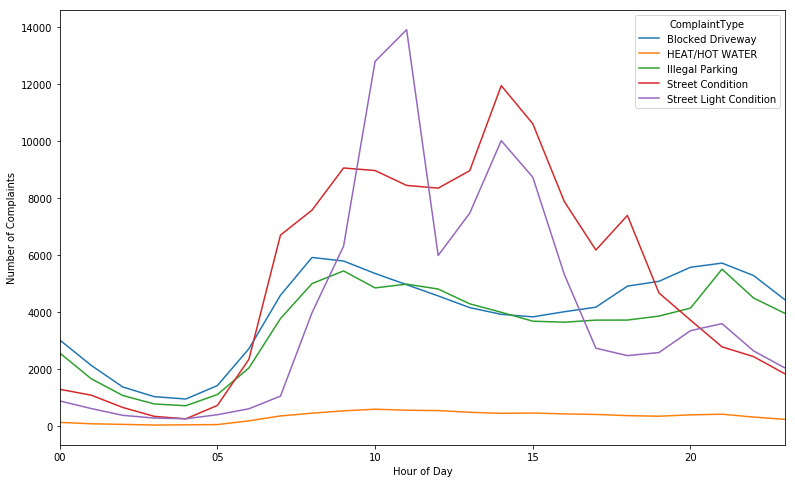

In [61]:
import matplotlib.pyplot as plt
df_pivot.plot(figsize=(13, 8))
plt.xlabel('Hour of Day')
plt.ylabel('Number of Complaints')
plt.show()

### Learn more

- Find more open data sets on [Data.gov](https://data.gov) and [NYC Open Data](https://nycopendata.socrata.com)
- Learn how to setup [MySql with Pandas and Plotly](http://moderndata.plot.ly/graph-data-from-mysql-database-in-python/)
- Big data workflows with [HDF5 and Pandas](http://stackoverflow.com/questions/14262433/large-data-work-flows-using-pandas)